<a href="https://colab.research.google.com/github/xixihaha1995/esp_proj3/blob/main/_4_toy_ASHRAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Energy Prediction based on Machine Learning


## Mount to GoogleDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/studying/Summer 2022/Project3/'
contnets = !ls 
print(contnets)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/studying/Summer 2022/Project3
["'_0_ Overview of Colaboratory Features'\t\t   _5_Toy_ASHRAE.ipynb", ' _1_Data_Preprocessing\t\t\t\t   data', "'_2_gradient descent and back_propogation.ipynb'   model", ' _3_defining_a_neural_network.ipynb\t\t   recycled', ' _4_training_with_pytorch.ipynb']


In [ ]:
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


## Import modules

In [ ]:
import os, time, numpy as np, pandas as pd, matplotlib.pyplot as plt

import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

## Hyperparameters and Neural Network related setups

In [ ]:
'''
Starting Simulation at 01/01/2017 for RUNPERIOD 1
Epoch timestamp 1483228800
Timestep = 15 mins * 60 seconds / min
'''
sim_start = 1483228800
sim_time_step = 15 * 60 

test_portion_factor = 0.3
lr = 0.001
hidden_dim=256
output_dim = 1
batch_size = 1024
'''
"OneHiddenLayer"
"GRU"
"LSTM"
'''
model_type_ = "GRU"
drop_prob_ = 0.2
n_layers = 2
lookback = 90
'''
new_cols[0] is the target y
new_cols[1:] are input x
'''
newline ='\n'
new_cols = ['elec_hvac[J]','month','dayofmonth','dayofweek', 'hour', 'minute',
        'oat[C]', 'solar[W/m2]']
if model_type_ == "OneHiddenLayer":
  EPOCHS=5
  print(f'Target variable:{newline}{new_cols[0]}')
  print(f'Input features:{newline}{new_cols[1:]}')
else:
  EPOCHS=5
  print(f'Target variable *  Lookback period:{newline}{new_cols[0]} * {lookback}')
  print(f'Input features * Lookahead period:{newline}{new_cols} * 1')

Target variable *  Lookback period:
elec_hvac[J] * 90
Input features * Lookahead period:
['elec_hvac[J]', 'month', 'dayofmonth', 'dayofweek', 'hour', 'minute', 'oat[C]', 'solar[W/m2]'] * 1


In [ ]:
def cvrmse_cal(measure, predict, mean_measured):
    rmse = (sum((measure - predict) ** 2) / len(measure)) ** (1 / 2)
    cvrmse = rmse * 100 / mean_measured
    return cvrmse

In [ ]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=drop_prob_):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=drop_prob_):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

class OneHiddenLayerNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=drop_prob_):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(input_dim, hidden_dim)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
  
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.output(self.relu(x))
        return x

In [ ]:
def train(model, train_loader, learn_rate, model_type, hidden_dim=256, EPOCHS=5):
    
    # Setting common hyperparameters
    # input_dim = next(iter(train_loader))[0].shape[2]
    # output_dim = 1
    # n_layers = 2
    # Instantiating the models
    # if model_type == "GRU":
    #     model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    # else:
    #     model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    # model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        if model_type == "GRU" or model_type == "LSTM":
          h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            elif model_type == "LSTM":
                h = tuple([e.data for e in h])
            
            model.zero_grad()
            if model_type == "GRU" or model_type == "LSTM":
              
              out, h = model(x.to(device).float(), h)
            else:
              out = model(x.to(device).float())
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%200 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Time Elapsed for Epoch: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

def evaluate(model, test_x, test_y, label_scalers, model_type_eva):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    for i in test_x.keys():
        inp = torch.from_numpy(np.array(test_x[i]))
        labs = torch.from_numpy(np.array(test_y[i]))
        if model_type_eva != "OneHiddenLayer":
          h = model.init_hidden(inp.shape[0])
          out, h = model(inp.to(device).float(), h)
        else:
          out= model(inp.to(device).float())
        outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        if model_type_eva == "OneHiddenLayer":
          labs = torch.reshape(labs,(-1,1))
        targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

In [ ]:
# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
def get_train_loader(model_type_load):
  print(f"get loader for model:{model_type_load}")

  label_scalers = {}

  train_x = []
  test_x = {}
  test_y = {}

  # for file in tqdm_notebook(os.listdir(data_dir)): 
  for file in os.listdir(data_dir): 
      # Skipping the files we're not using
      if file[-4:] != ".csv" or file == "pjm_hourly_est.csv":
          continue
      # Store csv file in a Pandas DataFrame
      df = pd.read_csv(data_dir + file, parse_dates=[0])
      # Processing the time data into suitable input formats


      df = pd.read_csv(data_dir + file)
      df.timestamp = pd.to_datetime(df.timestamp, unit='s')
      df['minute'] = df.apply(lambda x: x['timestamp'].minute, axis=1)
      df['hour'] = df.apply(lambda x: x['timestamp'].hour, axis=1)
      df['dayofweek'] = df.apply(lambda x: x['timestamp'].dayofweek, axis=1)
      df['dayofmonth'] = df.apply(lambda x: x['timestamp'].day, axis=1)
      df['month'] = df.apply(lambda x: x['timestamp'].month, axis=1)
      # new_cols = ['month','dayofmonth','dayofweek', 'hour', 'minute',
      #             'oat[C]', 'elec_hvac[J]','solar[W/m2]', 'zone_load_rate[W]']

      df = df.sort_values("timestamp").drop("timestamp", axis=1)
      df = df[new_cols]

      test_portion = int(test_portion_factor * len(df.values))
      df_train = df.iloc[:-test_portion]
      df_test = df.iloc[-test_portion:]
      # Scaling the input data
      sc = MinMaxScaler()
      label_sc = MinMaxScaler()
      data_train = sc.fit_transform(df_train.values)
      data_test = sc.transform(df_test.values)
      # Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
      label_sc.fit(df_train.iloc[:, 0].values.reshape(-1, 1))
      label_scalers[file] = label_sc

      # Use lookback period to split inputs/labels
      if model_type_load != "OneHiddenLayer":
        inputs_train = np.zeros((len(data_train) - lookback, lookback, df_train.shape[1]))
        labels_train = np.zeros(len(data_train) - lookback)
        for i in range(lookback, len(data_train)):
            inputs_train[i - lookback] = data_train[i - lookback:i] #Lookback period info
            labels_train[i - lookback] = data_train[i, 0] #Current target, input and label are not overlapped
        inputs_train = inputs_train.reshape(-1, lookback, df_train.shape[1])
        labels_train = labels_train.reshape(-1, 1)

        inputs_test = np.zeros((len(data_test) , lookback, df_test.shape[1]))
        labels_test = np.zeros(len(data_test) )
        scaled_tain_test_df = np.concatenate((data_train,data_test))
        for i in range(data_train.shape[0] , len(scaled_tain_test_df)):
            inputs_test[i - data_train.shape[0]] = scaled_tain_test_df[i - lookback:i]
            labels_test[i - data_train.shape[0]] = scaled_tain_test_df[i, 0]
        inputs_test = inputs_test.reshape(-1, lookback, df_test.shape[1])
        labels_test = labels_test.reshape(-1, 1)
      else:
        inputs_train = data_train[:, 1:]
        labels_train = data_train[:, 0]
        inputs_test = data_test[:, 1:]
        labels_test = data_test[:, 0]

      
      # Split data into train/test portions and combining all data from different files into a single array
      if len(train_x) == 0:
          train_x = inputs_train[:]
          train_y = labels_train[:]
      else:
          train_x = np.concatenate((train_x, inputs_train[:]))
          train_y = np.concatenate((train_y, labels_train[:]))

      test_x[file] = (inputs_test[:])
      test_y[file] = (labels_test[:])

      train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
      train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
      return label_scalers, test_x,test_y,train_x, train_y, train_data, train_loader

## Preview the training data

In [ ]:
# Define data root directory
from google.colab import data_table
data_table.enable_dataframe_formatter()

data_dir = "./data/"
preview_df = pd.read_csv(data_dir + 'pyep_results.csv')
preview_df.iloc[:100]

,timestamp,oat[C],elec_hvac[J],solar[W/m2],zone_load_rate[W]
0,1483228800,-6.0,119261608.6,0.0,21349.115130
1,1483229700,-5.0,119943039.8,0.0,287394.218900
2,1483230600,-4.0,113352487.4,0.0,104468.353900
3,1483231500,-3.0,124596405.9,0.0,8957.038971
4,1483232400,-3.0,118362007.9,0.0,201057.389000
...,...,...,...,...,...
95,1483314300,-7.0,131200475.4,0.0,204901.961500
96,1483315200,-7.5,120021735.3,0.0,6335.647078
97,1483316100,-8.0,107042614.4,0.0,300378.274400
98,1483317000,-8.5,121645350.1,0.0,135383.348000


## GPU for computation
CUDA tensor types, that implement the same function as CPU tensors, but they utilize GPUs for computation.

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f'Are we using GPU(CUDA)?:{is_cuda}')

Are we using GPU(CUDA)?:True


## Load training and testing data




### Scale train, then test

In [ ]:
'''
Get training and testing data
'''
label_scalers, test_x, test_y,train_x, train_y, train_data, train_loader = get_train_loader(model_type_)
print(train_x.shape)
print(train_y.shape)

get loader for model:GRU
(24438, 90, 8)
(24438, 1)


## Train or Load Models

In [ ]:
model_save_name = f'{model_type_}.pt'
model_path = F'/content/drive/MyDrive/studying/Summer 2022/Project3/model/{model_save_name}'
print(model_path)

/content/drive/MyDrive/studying/Summer 2022/Project3/model/GRU.pt


In [ ]:
'''
Define models
'''
if model_type_ == "OneHiddenLayer":
  input_dim = next(iter(train_loader))[0].shape[1]
else:
  input_dim = next(iter(train_loader))[0].shape[2]

if model_type_ == "GRU":
    chosen_model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
elif model_type_ == "LSTM":
    chosen_model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
else:
    chosen_model = OneHiddenLayerNet(input_dim, hidden_dim, output_dim, n_layers)
chosen_model.to(device)
'''
Get trained models
'''
if not os.path.isfile(model_path):
  print("Train from scratch")
  chosen_model = train(chosen_model, train_loader, lr, model_type_,hidden_dim, EPOCHS)
  torch.save(chosen_model.state_dict(), model_path)
else:
  print("Load the trained model")
  chosen_model.load_state_dict(torch.load(model_path))
chosen_model.to(device)
'''
Get predictions
'''
predicted_outputs, measured_outputs, gru_sMAPE = evaluate(chosen_model, test_x, test_y, label_scalers, model_type_)

Train from scratch
Starting Training of GRU model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Epoch 1/5 Done, Total Loss: 0.022934653715271015
Time Elapsed for Epoch: 1.5930540000000004 seconds
Epoch 2/5 Done, Total Loss: 0.005448020842817166
Time Elapsed for Epoch: 1.807568999999999 seconds
Epoch 3/5 Done, Total Loss: 0.0022268515566120977
Time Elapsed for Epoch: 1.7425300000000021 seconds
Epoch 4/5 Done, Total Loss: 0.0017119560836125975
Time Elapsed for Epoch: 1.7636709999999987 seconds
Epoch 5/5 Done, Total Loss: 0.0015505939246276798
Time Elapsed for Epoch: 1.813167 seconds
Total Training Time: 8.719991 seconds


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Evaluation Time: 0.21149799999999885
sMAPE: 1.1434263570593353%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [ ]:
'''
Re-organize the predictions
'''
test_start = sim_start + (lookback + train_x.shape[0]) * sim_time_step
date = [test_start + sim_time_step * i for i in range(predicted_outputs[0].shape[0])]
dataset = pd.DataFrame({'Predicted': predicted_outputs[0], 
                        'Measured': measured_outputs[0], "Date": np.array(date)})
dataset.Date  = pd.to_datetime(dataset.Date , unit='s')

mean_measured = abs(measured_outputs[0]).mean()
cvrmse = cvrmse_cal(measured_outputs[0],predicted_outputs[0], mean_measured)

In [ ]:
'''
Visualize the predictions and measurements
'''
import plotly.express as px

fig = px.line(dataset, x="Date", y=["Measured",'Predicted'])
fig.update_layout(
     title=f'Building Energy Consumption Prediction, CVRMSE:{cvrmse:.2f}%',
     yaxis_title="HVAC Electricity Consumption[J]",
     legend_title="Energy types",
     font=dict(
         family="Times New Roman",
         size=20,
         color="Black"
         )
     )
fig.show()

## Models performance comparison

In [ ]:
'''
Loading all trained models and get all predictions
'''
trained_model_names = ['GRU', 'LSTM', 'OneHiddenLayer']
predictions = {}

for model_type_local in trained_model_names:

  model_save_name = f'{model_type_local}.pt'
  model_path = F'/content/drive/MyDrive/studying/Summer 2022/Project3/model/{model_save_name}'

  label_scalers, test_x, test_y,train_x, train_y, train_data, train_loader_new = get_train_loader(model_type_local)

  if model_type_local == "OneHiddenLayer":
    input_dim = next(iter(train_loader_new))[0].shape[1]
  else:
    input_dim = next(iter(train_loader_new))[0].shape[2]
  if model_type_local == "GRU":
    cur_model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
  elif model_type_local == "LSTM":
    cur_model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
  else:
    cur_model = OneHiddenLayerNet(input_dim, hidden_dim, output_dim, n_layers)
  cur_model.load_state_dict(torch.load(model_path))
  cur_model.to(device)

  predicted_outputs, measured_outputs, gru_sMAPE = evaluate(cur_model, test_x, test_y, label_scalers,model_type_local)
  
  predictions[model_type_local] = predicted_outputs


get loader for model:GRU


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



Evaluation Time: 0.2174659999999946
sMAPE: 1.1434263570593353%
get loader for model:LSTM


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



Evaluation Time: 0.26753300000000024
sMAPE: 1.5554035799062855%
get loader for model:OneHiddenLayer
Evaluation Time: 0.0020319999999998117
sMAPE: 4.235940551083215%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: DeprecationWarning:

time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



In [ ]:
test_start = sim_start + (lookback + train_x.shape[0]) * sim_time_step
date = [test_start + sim_time_step * i for i in range(measured_outputs[0].shape[0])]
mean_measured = abs(measured_outputs[0]).mean()

dataset = pd.DataFrame({'OneHiddenLayer': predictions['OneHiddenLayer'][0], 
                        'GRU': predictions['GRU'][0], 
                        'LSTM': predictions['LSTM'][0], 
                        'Measured': measured_outputs[0], "Date": np.array(date)})
dataset.Date  = pd.to_datetime(dataset.Date , unit='s')

cvrmses = {}
for model_type_local in trained_model_names:
  cvrmse = cvrmse_cal(measured_outputs[0],predictions[model_type_local][0], mean_measured)
  cvrmses[model_type_local] = cvrmse

In [ ]:
import plotly.express as px
cvrmse_oneHiddenLayer = cvrmses['OneHiddenLayer']
cvrmse_LSTM = cvrmses['LSTM']
cvrmse_GRU = cvrmses['GRU']
fig = px.line(dataset, x="Date", y=["Measured",'OneHiddenLayer','GRU','LSTM'])
fig.update_layout(
     title=f"Prediction Performance (CVRMSE) <br>"
     f"OneHiddenLayer:<b>{cvrmse_oneHiddenLayer:.2f}</b>%;"
     f"LSTM:<b>{cvrmse_LSTM:.2f}</b>%;"
     f"GRU:<b>{cvrmse_GRU:.2f}</b>%",
     yaxis_title="HVAC Electricity Consumption[J]",
     legend_title="Energy types",
     font=dict(
         family="Times New Roman",
         size=12,
         color="Black"
         )
     )
fig.show()

# Beyond


1.   Another toy example, for Large Hotel at Denver instead of this Large Office building. 
2.   Try this [playground](https://playground.tensorflow.org/).
3. Try to spiral dataset challenge of the above link.



# Archived cells

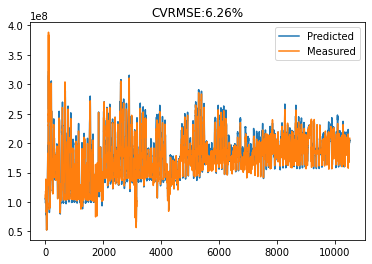

In [ ]:
plt.plot(gru_outputs[0], label = "Predicted")
plt.plot(targets[0], label = "Measured")
mean_measured = abs(targets[0]).mean()
cvrmse = cvrmse_cal(targets[0],gru_outputs[0], mean_measured)
plt.title(f'CVRMSE:{cvrmse:.2f}%')
plt.legend()
plt.show()

### Scaling the train and test

In [ ]:
# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
label_scalers = {}

train_x = []
test_x = {}
test_y = {}

# for file in tqdm_notebook(os.listdir(data_dir)): 
for file in os.listdir(data_dir): 
    # Skipping the files we're not using
    if file[-4:] != ".csv" or file == "pjm_hourly_est.csv":
        continue
    print(file)
    # Store csv file in a Pandas DataFrame
    df = pd.read_csv(data_dir + file, parse_dates=[0])
    # Processing the time data into suitable input formats


    df = pd.read_csv(data_dir + file)
    df.timestamp = pd.to_datetime(df.timestamp, unit='s')
    df['minute'] = df.apply(lambda x: x['timestamp'].minute, axis=1)
    df['hour'] = df.apply(lambda x: x['timestamp'].hour, axis=1)
    df['dayofweek'] = df.apply(lambda x: x['timestamp'].dayofweek, axis=1)
    df['dayofmonth'] = df.apply(lambda x: x['timestamp'].day, axis=1)
    df['month'] = df.apply(lambda x: x['timestamp'].month, axis=1)
    # new_cols = ['month','dayofmonth','dayofweek', 'hour', 'minute',
    #             'oat[C]', 'elec_hvac[J]','solar[W/m2]', 'zone_load_rate[W]']

    df = df.sort_values("timestamp").drop("timestamp", axis=1)
    df = df[new_cols]

    # df['hour'] = df.apply(lambda x: x['Datetime'].hour,axis=1)
    # df['dayofweek'] = df.apply(lambda x: x['Datetime'].dayofweek,axis=1)
    # df['month'] = df.apply(lambda x: x['Datetime'].month,axis=1)
    # df['dayofyear'] = df.apply(lambda x: x['Datetime'].dayofyear,axis=1)
    # df = df.sort_values("Datetime").drop("Datetime",axis=1)
    
    # Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)
    # Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
    label_sc.fit(df.iloc[:,0].values.reshape(-1,1))
    label_scalers[file] = label_sc
    
    # Use lookback period to split inputs/labels
    inputs = np.zeros((len(data)-lookback,lookback,df.shape[1]))
    labels = np.zeros(len(data)-lookback)
    
    for i in range(lookback, len(data)):
        inputs[i-lookback] = data[i-lookback:i]
        labels[i-lookback] = data[i,0]
    inputs = inputs.reshape(-1,lookback,df.shape[1])
    labels = labels.reshape(-1,1)
    
    # Split data into train/test portions and combining all data from different files into a single array
    test_portion = int(test_portion_factor*len(inputs))
    if len(train_x) == 0:
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x,inputs[:-test_portion]))
        train_y = np.concatenate((train_y,labels[:-test_portion]))
    test_x[file] = (inputs[-test_portion:])
    test_y[file] = (labels[-test_portion:])

pyep_results.csv
